In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# A function to compute and return vertical stress

def vert_stress(bases, gammas, gw, gamma_w=9.81):
    """
    Calculate vertical stress in a soil mass 
    consisting of a number of horizontal layers.
    The ground surface is at depth 0, and the layers are
    defined by their bases' depths and gammas arrays.
    
    Input:
    bases: array of layer bases' depths in meters
    gammas: array of layer unit weights in kN/m3
    gw: groundwater level in meters
    gamma_w: unit weight of water, kN/m3
    
    Output:
    sz_total: array of total vertical stress 
    u: array of pore water pressure 
    sz_eff: array of effective vertical stress

    Notice that the output arrays have one more element 
    than the input arrays, since the stresses start at 
    the ground surface (depth = 0.0)
    """
    
    # Check if the input arrays have the same length
    if len(bases) != len(gammas):
        print("Error: The input arrays must have the same length")
        return

    # Number of layers
    n = len(bases)
    
    # Initialize arrays
    sz_total = np.zeros(n+1) # total vertical stress
    u = np.zeros(n+1) # pore water pressure
    sz_eff = np.zeros(n+1) # effective vertical stress
    
    # insert 0 at start of bases since the ground surface is at depth 0
    bases = np.insert(bases, 0, 0)
    
    # Calculate stresses
    for i in range(n):
        # total vertical stress at the base of the layer
        sz_total[i+1] = sz_total[i] + gammas[i]*(bases[i+1] - bases[i])
        # pore water pressure at the base of the layer
        if bases[i+1] > gw:
            u[i+1] = gamma_w*(bases[i+1] - gw)
        # effective vertical stress at the base of the layer      
        sz_eff[i+1] = sz_total[i+1] - u[i+1]

    return sz_total, u, sz_eff

# a function to compute vertical strain
def vert_strain(sigma_0, delta_sigma, modulus, model=1):
    """
    Calculate vertical strain in a soil mass 
    due to a change in vertical stress.
    
    Input:
    sigma_0: initial effective vertical stress (kPa)
    delta_sigma: change in effective vertical stress (kPa)
    modulus: soil modulus number
    
    Output:
    epsilon: vertical strain
    """

    # make sure model is either 1, 2, or 3
    if model not in [1, 2, 3]:
        print("Error: model must be either 1, 2, or 3")
        return
    
    # reference stress: atmospheric pressure
    sigma_ref = 100 # kPa

    # calculate vertical strain
    if model == 1:
        # elastic model, rock, morraine, OC-clay
        epsilon = delta_sigma / (modulus*sigma_ref)
    elif model == 2:
        # elasto-plastic model, sand, coarse silt
        epsilon = (2.0/modulus)*(np.sqrt((sigma_0 + delta_sigma)/sigma_ref) - np.sqrt(sigma_0/sigma_ref))
    elif model == 3:
        # plastic model, NC-clay, fine silt
        epsilon = (1.0/modulus)*np.log((sigma_0 + delta_sigma)/sigma_0)
    
    return epsilon

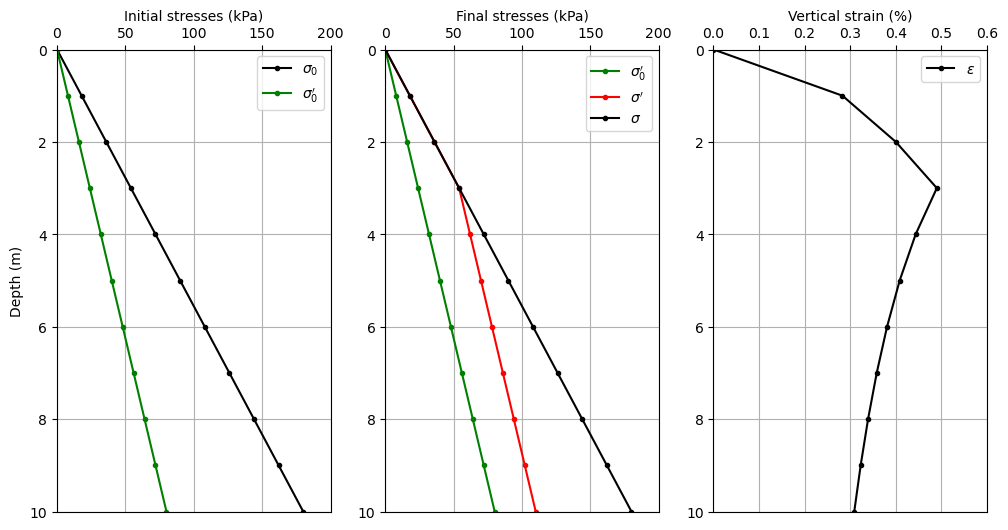

Settlement = 36 mm


In [3]:
# Lecture 10, Example 1 (4.2 i Aarhaug, 1992, Geoteknikk):
interval = 1 # interval between layers
depth_f = 10 # final depth
bases = np.arange(interval, depth_f+interval, interval)
gammas = np.ones(len(bases))*18
gw = 0 # groundwater at the ground surface
gamma_w = 10.0

# initial stresses
sz_total_o, u_o, sz_eff_o = vert_stress(bases, gammas, gw, gamma_w)

# final stresses
gw = 3 # groundwater at 3 meters depth
sz_total_f, u_f, sz_eff_f = vert_stress(bases, gammas, gw, gamma_w)

# now let's get what we need to compute vertical strain
sigma_0 = sz_eff_o
delta_sigma = sz_eff_f - sz_eff_o
modulus = 100 # modulus number
model = 2 # elasto-plastic model, sand
epsilon = np.zeros(len(sigma_0))
for i in range(len(epsilon)):
    epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus, model)

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
depths = np.arange(0, depth_f+interval, interval)
# initial stresses
ax[0].plot(sz_total_o, depths, 'k.-', label=r'$\sigma_0$')
ax[0].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[0].set_ylabel('Depth (m)')

# final stresses
ax[1].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[1].plot(sz_eff_f, depths, 'r.-', label=r"$\sigma'$")
ax[1].plot(sz_total_f, depths, 'k.-', label=r'$\sigma$')

# vertical strain
ax[2].plot(epsilon*100, depths, 'k.-', label=r'$\epsilon$')

# common settings
x_labels = ['Initial stresses (kPa)', 'Final stresses (kPa)', 'Vertical strain (%)']
xmax = [200, 200, 0.6]
for i in range(3):
    ax[i].legend()
    ax[i].xaxis.set_label_position('top')
    ax[i].xaxis.tick_top()
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_xlim(0, xmax[i])
    ax[i].set_ylim(depth_f, 0)
    ax[i].grid()

plt.show()

# settlement is area under the curve of the vertical strain plot
settlement = np.trapezoid(epsilon, depths)
print(f"Settlement = {settlement*1e3:.0f} mm")

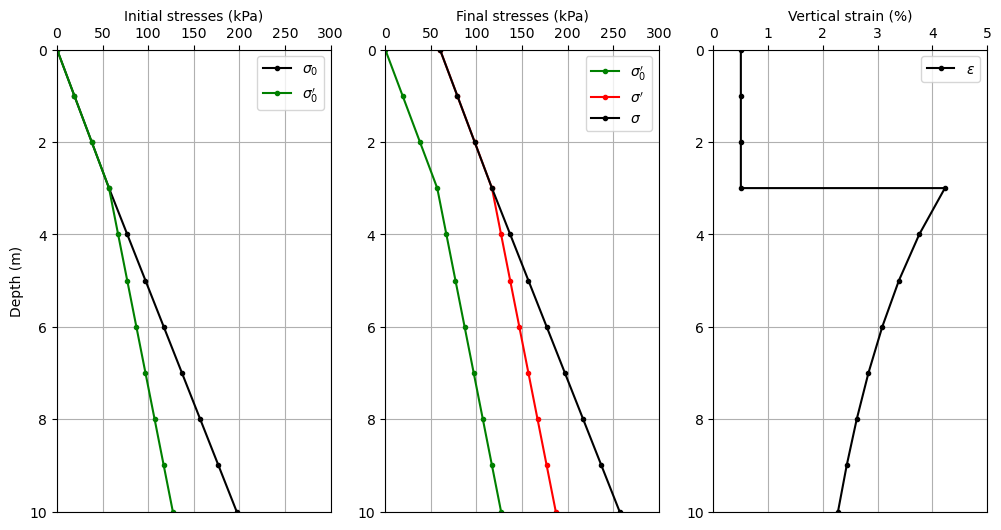

Settlement = 229 mm


In [4]:
# Lecture 10, Example 2: (4.3 i Aarhaug, 1992, Geoteknikk)
interval = 1
depth_f = 10
bases = np.arange(interval, depth_f+interval, interval)
gammas = np.zeros(len(bases))
# if bases <=3 gammas are 19, else they are 20 kN/m3
gammas[bases <= 3] = 19
gammas[bases > 3] = 20
gw = 3 # groundwater at 3 meters depth
gamma_w = 10.0 # unit weight of water kN/m3

# initial stresses
sz_total_o, u_o, sz_eff_o = vert_stress(bases, gammas, gw, gamma_w)

# final stresses
sz_total_f = sz_total_o + 60 # increase in vertical stress by 60 kPa
sz_eff_f = sz_eff_o + 60 # increase in effective vertical stress by 60 kPa

# sigma_0
index = np.argmin(np.abs(bases - 3.0)) +1 # index for stress at 3 meters depth
sigma_0_oc = sz_eff_o[0:index+1] # sigma_0 for OC-clay
sigma_0_nc = sz_eff_o[index:] # sigma_0 for NC-clay

# now concatenate these two arrays
sigma_0 = np.concatenate((sigma_0_oc, sigma_0_nc))

# delta_sigma
delta_sigma = np.ones(len(sigma_0))*60 

# modulus and model
modulus = [120, 17]
model = [1, 3]

# vertical strain
epsilon = np.zeros(len(sigma_0))
for i in range(len(epsilon)):
    # OC-clay
    if i <= index:
        epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus[0], model[0])
    # NC-clay
    else:
        epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus[1], model[1])

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
depths = np.arange(0, depth_f+interval, interval)

# initial stresses
ax[0].plot(sz_total_o, depths, 'k.-', label=r'$\sigma_0$')
ax[0].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[0].set_ylabel('Depth (m)')

# final stresses
ax[1].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[1].plot(sz_eff_f, depths, 'r.-', label=r"$\sigma'$")
ax[1].plot(sz_total_f, depths, 'k.-', label=r'$\sigma$')

# vertical strain
# we need to be careful because epsilon is repeated at 
# the interface between OC-clay and NC-clay
# so we need to modify the depths array
depths = np.concatenate((depths[0:index+1], depths[index:]))
ax[2].plot(epsilon*100, depths, 'k.-', label=r'$\epsilon$')

# common settings
x_labels = ['Initial stresses (kPa)', 'Final stresses (kPa)', 'Vertical strain (%)']
xmax = [300, 300, 5]
for i in range(3):
    ax[i].legend()
    ax[i].xaxis.set_label_position('top')
    ax[i].xaxis.tick_top()
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_xlim(0, xmax[i])
    ax[i].set_ylim(depth_f, 0)
    ax[i].grid()

plt.show()

# settlement is area under the curve of the vertical strain plot
settlement = np.trapezoid(epsilon, depths)
print(f"Settlement = {settlement*1e3:.0f} mm")

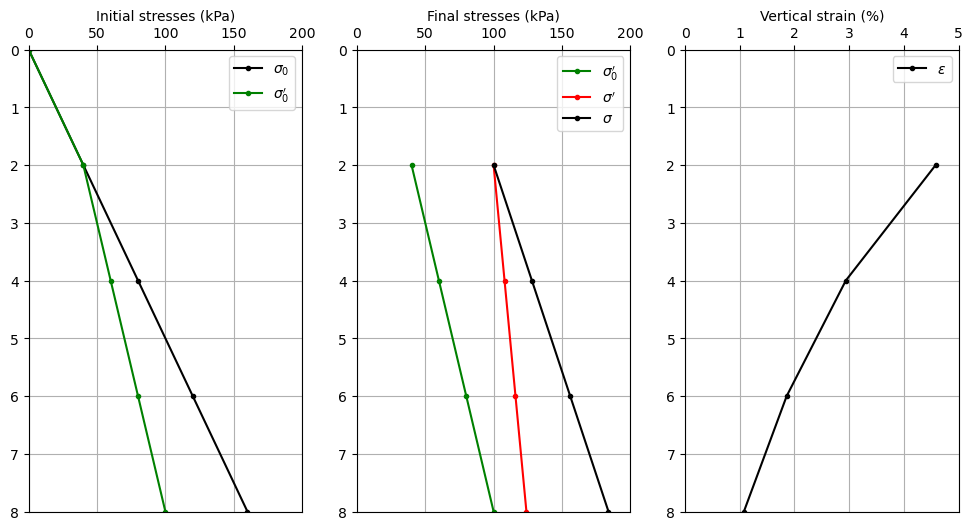

Settlement = 153 mm


In [5]:
# Lecture 10, Example 3: (4.4 i Aarhaug, 1992, Geoteknikk)
interval = 2
depth_f = 8
bases = np.arange(interval, depth_f+interval, interval)
gammas = np.ones(len(bases))*20
gw = 2 # groundwater at 2 meters depth
gamma_w = 10.0 # unit weight of water kN/m3

# initial stresses
sz_total_o, u_o, sz_eff_o = vert_stress(bases, gammas, gw, gamma_w)

# the sole foundation is at 2 meters depth
# delta_sigma at 2, 4, 6 and 8 m below the
# foundation is 60, 48, 36, 24 kPa (stress distribution graph)
delta_sigma = np.array([60, 48, 36, 24])

# final stresses
sz_total_f = sz_total_o[1:] + delta_sigma
sz_eff_f = sz_eff_o[1:] + delta_sigma

# sigma_0
sigma_0 = sz_eff_o[1:]

# modulus and model
modulus = 20
model = 3

# vertical strain
epsilon = np.zeros(len(sigma_0))
for i in range(len(epsilon)):
    epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus, model)

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
depths = np.arange(0, depth_f+interval, interval)

# initial stresses
ax[0].plot(sz_total_o, depths, 'k.-', label=r'$\sigma_0$')
ax[0].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")

# final stresses
ax[1].plot(sz_eff_o[1:], depths[1:], 'g.-', label=r"$\sigma_0'$")
ax[1].plot(sz_eff_f, depths[1:], 'r.-', label=r"$\sigma'$")
ax[1].plot(sz_total_f, depths[1:], 'k.-', label=r'$\sigma$')

# vertical strain
ax[2].plot(epsilon*100, depths[1:], 'k.-', label=r'$\epsilon$')

# common settings
x_labels = ['Initial stresses (kPa)', 'Final stresses (kPa)', 'Vertical strain (%)']
xmax = [200, 200, 5]
for i in range(3):
    ax[i].legend()
    ax[i].xaxis.set_label_position('top')
    ax[i].xaxis.tick_top()
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_xlim(0, xmax[i])
    ax[i].set_ylim(depth_f, 0)
    ax[i].grid()

plt.show()

# settlement is area under the curve of the vertical strain plot
settlement = np.trapezoid(epsilon, depths[1:])
print(f"Settlement = {settlement*1e3:.0f} mm")

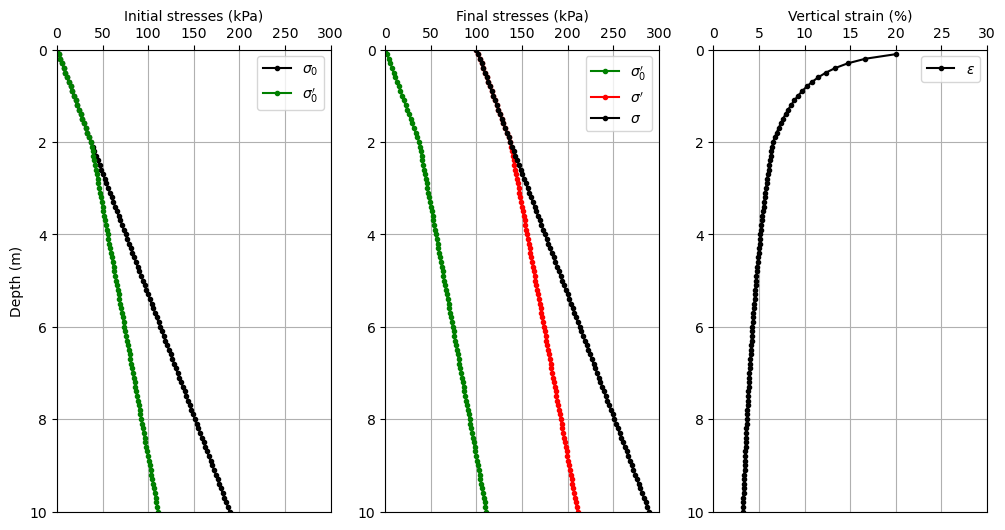

Settlement = 558 mm


In [6]:
# Exercise (oppgave) 4.1 i Aarhaug (1992) Geoteknikk
interval = 0.1
depth_f = 10
bases = np.arange(interval, depth_f+interval, interval)
gammas = np.zeros(len(bases))
# if bases <=2 gammas are 1.89*g, else they are 1.94*g kN/m3
g = 9.81 # gravity in m/s2
gammas[bases <= 2] = 1.89*g
gammas[bases > 2] = 1.94*g
# groundwater at 2 meters depth
gw = 2.0 
# unit weight of water kN/m3
gamma_w = 1.0*g

# initial stresses
sz_total_o, u_o, sz_eff_o = vert_stress(bases, gammas, gw, gamma_w)

# final stresses
sz_total_f = sz_total_o + 100 # increase in vertical stress by 100 kPa
sz_eff_f = sz_eff_o + 100 # increase in effective vertical stress by 100 kPa

# sigma_0
sigma_0 = sz_eff_o

# delta_sigma
delta_sigma = np.ones(len(sigma_0))*100 

# modulus and model
modulus = [20]
model = [3]

# vertical strain
epsilon = np.zeros(len(sigma_0))
# don't start from 0, since this leads to division by zero
for i in range(1,len(epsilon)):
    # NC-clay
    epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus[0], model[0])

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
depths = np.arange(0, depth_f+interval, interval)

# initial stresses
ax[0].plot(sz_total_o, depths, 'k.-', label=r'$\sigma_0$')
ax[0].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[0].set_ylabel('Depth (m)')

# final stresses
ax[1].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[1].plot(sz_eff_f, depths, 'r.-', label=r"$\sigma'$")
ax[1].plot(sz_total_f, depths, 'k.-', label=r'$\sigma$')

# vertical strain
# start from 1 to avoid division by zero
ax[2].plot(epsilon[1:]*100, depths[1:], 'k.-', label=r'$\epsilon$')

# common settings
x_labels = ['Initial stresses (kPa)', 'Final stresses (kPa)', 'Vertical strain (%)']
xmax = [300, 300, 30]
for i in range(3):
    ax[i].legend()
    ax[i].xaxis.set_label_position('top')
    ax[i].xaxis.tick_top()
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_xlim(0, xmax[i])
    ax[i].set_ylim(depth_f, 0)
    ax[i].grid()

plt.show()

# settlement is area under the curve of the vertical strain plot
settlement = np.trapezoid(epsilon, depths)
print(f"Settlement = {settlement*1e3:.0f} mm")

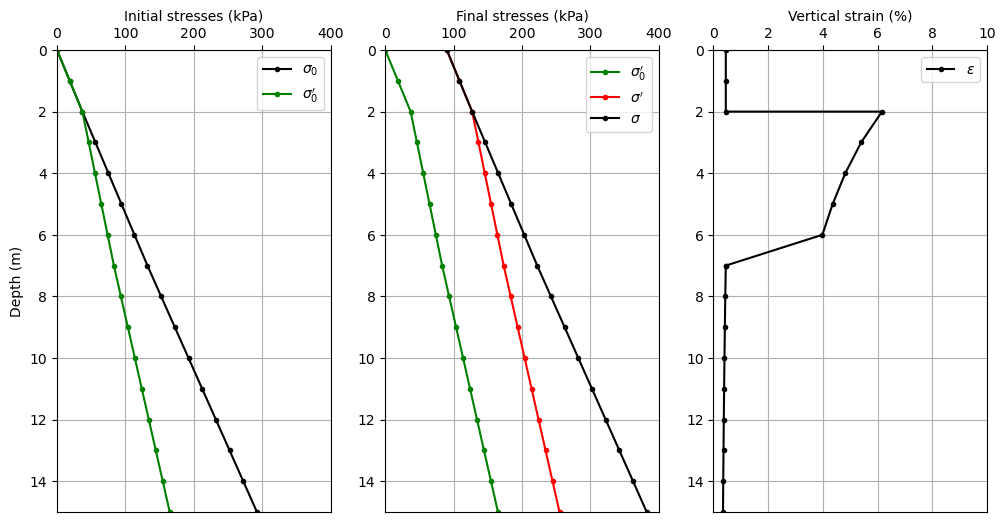

Settlement = 259 mm


In [7]:
# Exercise (oppgave) 4.2 i Aarhaug (1992) Geoteknikk
interval = 1.0
depth_f = 15
bases = np.arange(interval, depth_f+interval, interval)
gammas = np.zeros(len(bases))
# set gammas values based on soil type
g = 9.81 # gravity in m/s2
gammas[bases <= 2] = 1.89*g
gammas[(bases > 2) & (bases <= 7)] = 1.94*g
gammas[bases > 7] = 2.04*g
# groundwater at 2 meters depth
gw = 2.0
# unit weight of water kN/m3
gamma_w = 1.0*g

# initial stresses
sz_total_o, u_o, sz_eff_o = vert_stress(bases, gammas, gw, gamma_w)

# final stresses
sz_total_f = sz_total_o + 90 # increase in vertical stress by 90 kPa
sz_eff_f = sz_eff_o + 90 # increase in effective vertical stress by 90 kPa

# sigma_0
index_2 = np.argmin(np.abs(bases - 2.0)) +1 # index for stress at 2 meters depth
index_7 = np.argmin(np.abs(bases - 7.0)) +1 # index for stress at 7 meters depth
sigma_0_oc = sz_eff_o[0:index_2+1] # sigma_0 for OC-clay
sigma_0_nc = sz_eff_o[index_2:index_7+1] # sigma_0 for NC-clay
sigma_0_s = sz_eff_o[index_7:] # sigma_0 for sand

# now concatenate these three arrays
sigma_0 = np.concatenate((sigma_0_oc, sigma_0_nc, sigma_0_s))

# delta_sigma
delta_sigma = np.ones(len(sigma_0))*90 

# modulus and model
modulus = [200, 20, 180]
model = [1, 3, 2]

# vertical strain
epsilon = np.zeros(len(sigma_0))
for i in range(len(epsilon)):
    # OC-clay
    if i <= index_2:
        epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus[0], model[0])
    else:
        # NC-clay
        if i <= index_7:
            epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus[1], model[1])
        # sand
        else:
            epsilon[i] = vert_strain(sigma_0[i], delta_sigma[i], modulus[2], model[2])

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
depths = np.arange(0, depth_f+interval, interval)

# initial stresses
ax[0].plot(sz_total_o, depths, 'k.-', label=r'$\sigma_0$')
ax[0].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[0].set_ylabel('Depth (m)')

# final stresses
ax[1].plot(sz_eff_o, depths, 'g.-', label=r"$\sigma_0'$")
ax[1].plot(sz_eff_f, depths, 'r.-', label=r"$\sigma'$")
ax[1].plot(sz_total_f, depths, 'k.-', label=r'$\sigma$')

# vertical strain
# we need to be careful because epsilon is repeated at 
# the interface between OC-clay and NC-clay,and NC-clay 
# and sand, so we need to modify the depths array
depths = np.concatenate((depths[0:index_2+1], 
                         depths[index_2:index_7+1], depths[index_7:]))
ax[2].plot(epsilon*100, depths, 'k.-', label=r'$\epsilon$')

# common settings
x_labels = ['Initial stresses (kPa)', 'Final stresses (kPa)', 'Vertical strain (%)']
xmax = [400, 400, 10]
for i in range(3):
    ax[i].legend()
    ax[i].xaxis.set_label_position('top')
    ax[i].xaxis.tick_top()
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_xlim(0, xmax[i])
    ax[i].set_ylim(depth_f, 0)
    ax[i].grid()

plt.show()

# settlement is area under the curve of the vertical strain plot
settlement = np.trapezoid(epsilon, depths)
print(f"Settlement = {settlement*1e3:.0f} mm")